In [ ]:
# %%

import os
from einops import repeat
import torch
from PIL import Image
import requests

# url = 'https://private-user-images.githubusercontent.com/7107196/177920383-161f1da1-33f9-48b3-b8b2-09e450432e2b.mp4?jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3MjMwNDUxNDAsIm5iZiI6MTcyMzA0NDg0MCwicGF0aCI6Ii83MTA3MTk2LzE3NzkyMDM4My0xNjFmMWRhMS0zM2Y5LTQ4YjMtYjhiMi0wOWU0NTA0MzJlMmIubXA0P1gtQW16LUFsZ29yaXRobT1BV1M0LUhNQUMtU0hBMjU2JlgtQW16LUNyZWRlbnRpYWw9QUtJQVZDT0RZTFNBNTNQUUs0WkElMkYyMDI0MDgwNyUyRnVzLWVhc3QtMSUyRnMzJTJGYXdzNF9yZXF1ZXN0JlgtQW16LURhdGU9MjAyNDA4MDdUMTUzNDAwWiZYLUFtei1FeHBpcmVzPTMwMCZYLUFtei1TaWduYXR1cmU9YTgwYjg4ZGZjOTdhMWQwYmZiNTg2YTQ2YTZkMDI5NmQ2NGQ0MmJlNmI4YzFmNTAxMjE5YTc1ZDUxZjAxMjUwOCZYLUFtei1TaWduZWRIZWFkZXJzPWhvc3QmYWN0b3JfaWQ9MCZrZXlfaWQ9MCZyZXBvX2lkPTAifQ.TwtWs6lmjwwGXhgbDDCeO9phqwjDFoAvcCkL0hVQZOs'
# # save the video
# def download_file(url, filename):
#     r = requests.get(url, stream=True)
#     with open(filename, 'wb') as f:
#         f.write(r.content)
#     return filename
# video_path = download_file(url, './tmp/video.mp4')
video_path = './tmp/video.mp4'

In [ ]:
from einops import rearrange
from torch import nn

class VideoMAE(nn.Module):
    def __init__(self, layer=11, **kwargs):
        super().__init__()

        try:
            from transformers import VideoMAEForVideoClassification
        except ImportError:
            raise ImportError(
                "Please install the transformers library: pip install transformers"
            )

        self.model = VideoMAEForVideoClassification.from_pretrained(
            "MCG-NJU/videomae-base-finetuned-kinetics"
        )
        self.model.requires_grad_(False)
        self.model.eval()
        
        self.layer = layer

    def forward(self, x):
        assert x.dim() == 5
        assert x.shape[1:] == (16, 3, 224, 224)  # frame, color channel, height, width

        outputs = self.model(x, output_hidden_states=True, return_dict=True)
        layer_idx = - (12 - self.layer)
        return outputs.hidden_states[layer_idx] 
        # last_layer = outputs.hidden_states[-1]
        # return last_layer


from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import numpy as np


def transform_images(frames, size=(224, 224)):
    resized = []
    length = len(frames)
    for i in range(length):
        frame = frames[i]
        # image = Image.fromarray((frame * 255).astype(np.uint8))
        image = Image.fromarray(frame)
        image = image.resize(size, Image.ANTIALIAS)
        image = np.array(image) / 255.0
        resized.append(np.array(image))
    frames = np.stack(resized, axis=0)
    frames = frames.transpose(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
    frames = torch.tensor(frames, dtype=torch.float32)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    frames = (frames - mean) / std
    return frames


def read_video(video_path: str) -> torch.Tensor:
    try:
        from decord import VideoReader
    except ImportError:
        raise ImportError("Please install the decord library: pip install decord")

    vr = VideoReader(video_path)
    print(f"Total frames: {len(vr)}")
    # frames = vr.get_batch(range(len(vr))).asnumpy()
    lenth = len(vr)
    lenth = 1600 if lenth > 1600 else lenth
    frames = vr.get_batch(np.arange(lenth)).asnumpy()
    # if less than 1600 frames, repeat the last frame
    if lenth < 1600:
        last_frame = frames[-1]
        for i in range(1600 - lenth):
            frames = np.append(frames, last_frame.reshape(1, *last_frame.shape), axis=0)
    # frames = np.array(frames)
    frames = transform_images(frames)
    return frames


def video_mae_feature(video_path, layer=11):
    frames = read_video(video_path)
    videomae = VideoMAE(layer=layer)
    videomae = videomae.cuda()
    frames = frames.cuda()
    frames = rearrange(frames, "(b t) c h w -> b t c h w", affinity_focal_gamma=16)
    feats = videomae(frames)
    return feats


In [ ]:
# %%

features = video_mae_feature(video_path, layer=11)
print("Features shape:", features.shape)  # "Features shape: torch.Size([1600, 768])

Total frames: 2490
Features shape: torch.Size([100, 1568, 768])


In [ ]:
# %%

from ncut_pytorch import NCUT

t, n, c = features.shape
features = features.reshape(t * n, c)
model = NCUT(num_eig=20)
eigenvectors, eigenvalues = model.fit_transform(features)
print("Eigenvalues:", eigenvalues)
print("Eigenvectors shape:", eigenvectors.shape)

Eigenvalues: tensor([1.0000, 0.0388, 0.0378, 0.0296, 0.0216, 0.0175, 0.0169, 0.0148, 0.0128,
        0.0116, 0.0113, 0.0102, 0.0098, 0.0094, 0.0083, 0.0079, 0.0071, 0.0067,
        0.0064, 0.0056], device='cuda:0')
Eigenvectors shape: torch.Size([156800, 20])


In [ ]:
# %%

from ncut_pytorch import rgb_from_tsne_3d

X_3d, rgb = rgb_from_tsne_3d(eigenvectors, perplexity=100)

In [ ]:
# %%

rgb = rgb.reshape(800, 14, 14, 3)
print("RGB shape:", rgb.shape)  # "RGB shape: torch.Size([1600, 14, 14, 3])
rgb = repeat(rgb, 't h w c -> t n h w c', n=2)
rgb = rgb.reshape(1600, 14, 14, 3)

RGB shape: torch.Size([800, 14, 14, 3])


In [ ]:
# %%

import matplotlib.pyplot as plt
from decord import VideoReader

vr = VideoReader(video_path)

import matplotlib.gridspec as gridspec
def get_one_plot(i_frame, vr=vr, rgb=rgb):
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.8, 1])

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])

    frames = vr[i_frame]
    ax0.imshow(frames.asnumpy())
    ax0.set_title(f"Frame {i_frame:04d}")
    ax0.axis("off")

    ax1.imshow(rgb[i_frame])
    ax1.set_title(f"Ncut(VideoMAE,layer11)\n 3D spectral-tSNE, 20 eigenvectors")
    ax1.axis("off")

    plt.show()

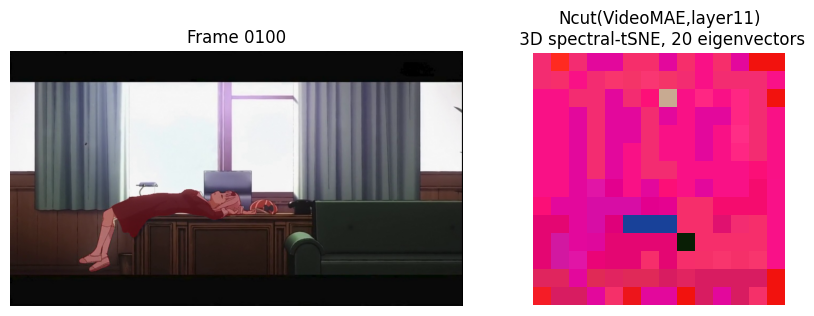

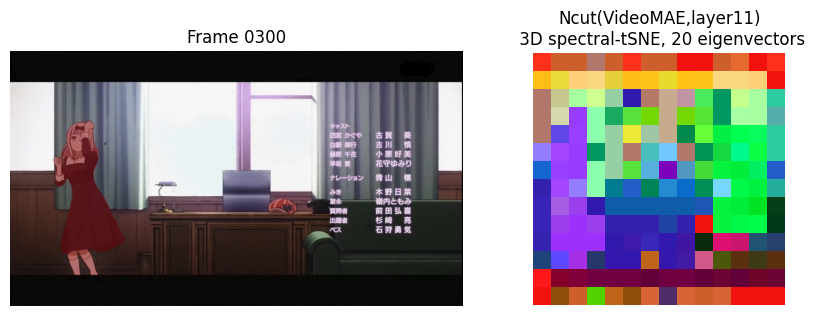

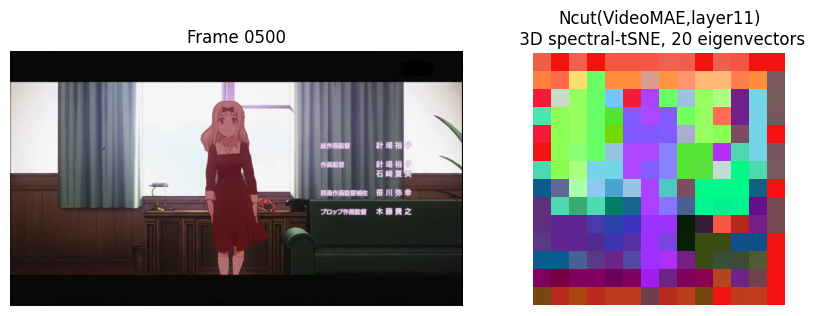

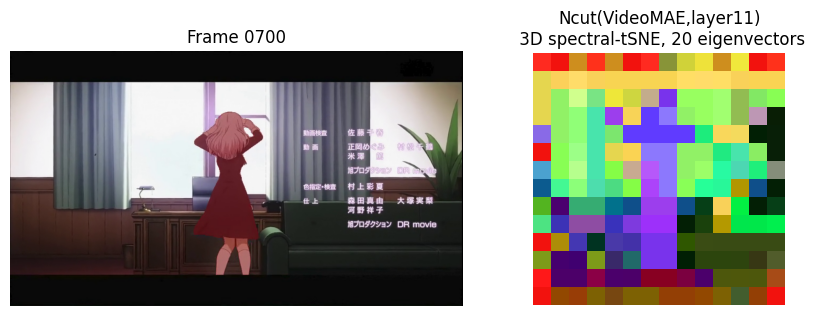

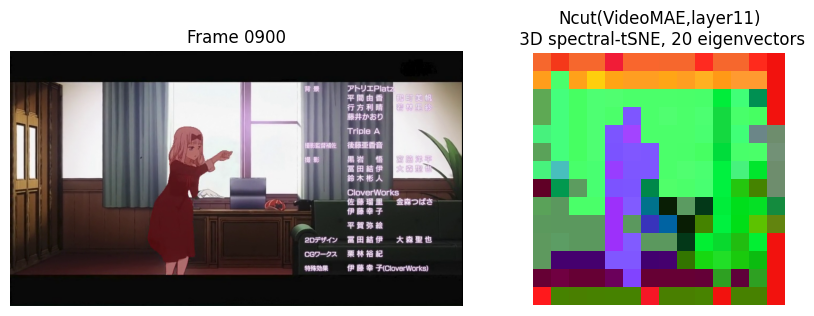

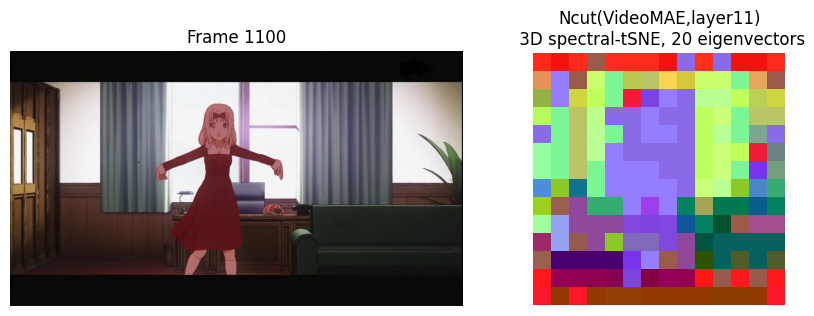

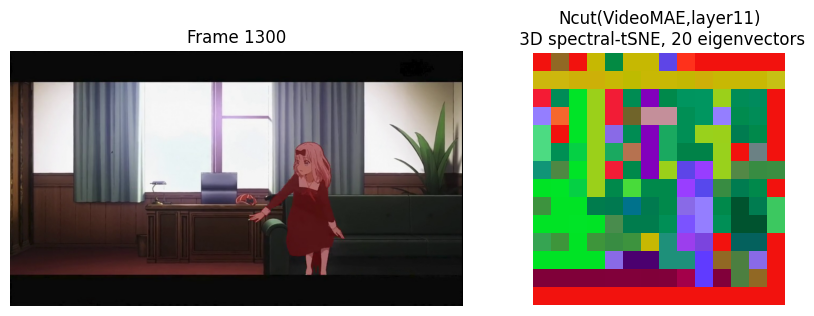

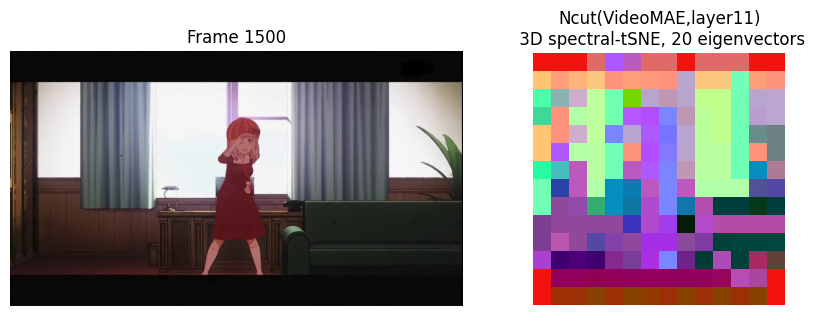

In [ ]:
# %%
# show some frames
for i in range(100, 1600, 200):
    get_one_plot(i)